In [1]:
#### Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)

In [2]:
## Load TRAINING data ONLY (19 samples)

train_path = "train_file"
df = pd.read_csv(train_path)

X = df.iloc[:, :-1]
y = df["Label"]

print("Samples:", X.shape[0])
print("Features:", X.shape[1])
print("Labels:", y.value_counts().to_dict())

Samples: 18
Features: 39
Labels: {1: 12, 0: 6}


In [3]:
####### Models + parameter grids

models = {
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "ExtraTrees": ExtraTreesClassifier()
}

param_grids = {
    "SVM": {
        "C": [0.01, 0.1, 1, 10],
        "gamma": ["scale", 1e-3, 1e-2],
        "kernel": ["rbf"]
    },
    "RandomForest": {
        "n_estimators": [200, 500],
        "max_depth": [None, 5, 10]
    },
    "AdaBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3]
    },
    "ExtraTrees": {
        "n_estimators": [200, 500],
        "max_depth": [None, 5, 10]
    }
}

In [4]:
####### RFE ESTIMATORS #######

rfe_estimators = {
    "SVM": LinearSVC(dual=False, max_iter=5000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, random_state=42)
}

In [5]:
####### Selected Features #####

selected_features = {}

for name, rfe_model in rfe_estimators.items():
    rfe = RFE(rfe_model, n_features_to_select=5)
    rfe.fit(X, y)
    selected_features[name] = X.columns[rfe.support_].tolist()
    print(f"{name} top-5 genes:", selected_features[name])


SVM top-5 genes: ['CCDC190', 'CXCR2', 'INHBA', 'MMP1', 'SAA2-SAA4']
RandomForest top-5 genes: ['IL20', 'INHBA', 'MMP1', 'RPE65', 'SAA2-SAA4']
AdaBoost top-5 genes: ['RPE65', 'SERPINE1', 'SLC6A17', 'ST6GAL2', 'ZSWIM9']
GradientBoosting top-5 genes: ['RPE65', 'SERPINE1', 'SLC6A17', 'ST6GAL2', 'ZSWIM9']
ExtraTrees top-5 genes: ['IGF2BP2', 'IL20', 'INHBA', 'RPE65', 'SAA2-SAA4']


In [6]:
####### RFE (Top-5) + LOOCV (CORE)

loo = LeaveOneOut()

results = {}
scores_for_plot = {}

for name, model in models.items():
    print(f"\nRunning LOOCV for {name}")

    X_sel = X[selected_features[name]]

    y_true_all = []
    y_score_all = []

    for train_idx, test_idx in loo.split(X_sel):
        X_train, X_test = X_sel.iloc[train_idx], X_sel.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        search = RandomizedSearchCV(
            model,
            param_grids[name],
            n_iter=10,
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        if hasattr(best_model, "predict_proba"):
            score = best_model.predict_proba(X_test)[0, 1]
        else:
            score = best_model.decision_function(X_test)[0]

        y_true_all.append(y_test.values[0])
        y_score_all.append(score)

    y_true_all = np.array(y_true_all)
    y_score_all = np.array(y_score_all)

    auroc = roc_auc_score(y_true_all, y_score_all)
    auprc = average_precision_score(y_true_all, y_score_all)

    results[name] = {
        "AUROC": auroc,
        "AUPRC": auprc,
        "Top5_Genes": selected_features[name]
    }

    scores_for_plot[name] = (y_true_all, y_score_all)

    print("AUROC:", round(auroc, 3))
    print("AUPRC:", round(auprc, 3))


Running LOOCV for SVM
AUROC: 1.0
AUPRC: 1.0

Running LOOCV for RandomForest


/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
 

AUROC: 0.986
AUPRC: 0.994

Running LOOCV for AdaBoost


/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
 

AUROC: 0.958
AUPRC: 0.972

Running LOOCV for GradientBoosting


/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
 

AUROC: 0.917
AUPRC: 0.972

Running LOOCV for ExtraTrees


/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/piyushagrawal/miniconda/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
 

AUROC: 0.972
AUPRC: 0.988


In [8]:
#### Save result

results_df = pd.DataFrame(results).T
results_df.to_csv("LOOCV_RFE_top5_all_models.csv")
print("\n✅ Results saved")


✅ Results saved


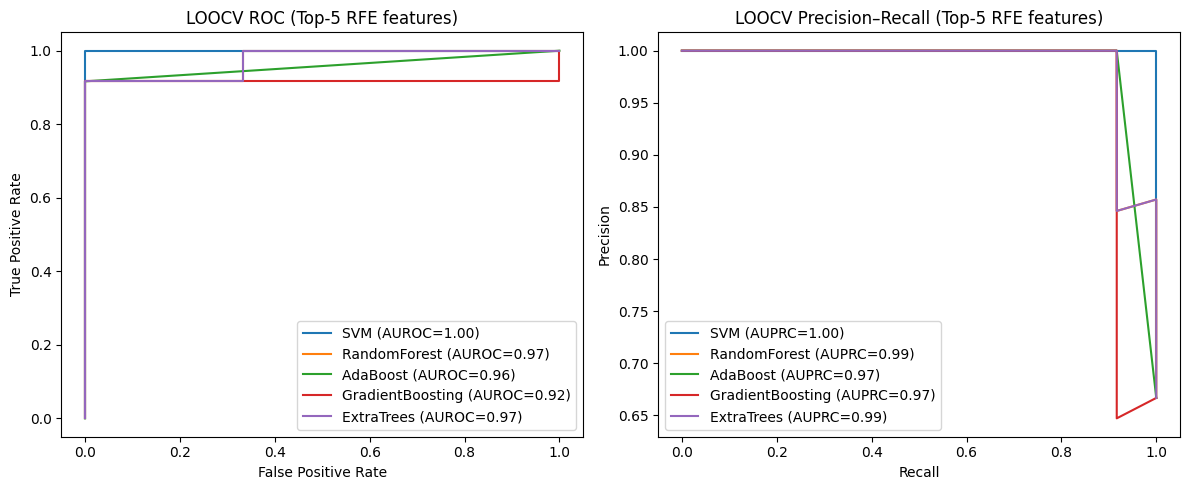

✅ ROC & PR plots saved


In [8]:
##### Plot ROC & PR curves

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.title("LOOCV ROC (Top-5 RFE features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# PR
plt.subplot(1, 2, 2)
plt.title("LOOCV Precision–Recall (Top-5 RFE features)")
plt.xlabel("Recall")
plt.ylabel("Precision")

for name, (y_true, y_score) in scores_for_plot.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)

    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auroc:.2f})")

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"{name} (AUPRC={auprc:.2f})")

plt.subplot(1, 2, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.legend()

plt.tight_layout()
plt.savefig("LOOCV_RFE_top5_ROC_PR.png", dpi=600)
plt.show()

print("✅ ROC & PR plots saved")